In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
data = pd.read_csv(url, names=columns, sep=',', skipinitialspace=True, na_values="?")
data = data.dropna()

# Label encode categorical variables
categorical_cols = data.select_dtypes(include='object').columns
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# Normalize features
X = data.drop('income', axis=1)
y = data['income']
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Input Perturbation (Add noise to features)

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def add_input_noise(X, epsilon, sensitivity=1.0, mechanism="laplace"):
    X_noisy = X.copy()
    if mechanism == "laplace":
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=X.shape)
    elif mechanism == "gaussian":
        sigma = sensitivity / epsilon
        noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    else:
        raise ValueError("Unsupported mechanism.")
    return X_noisy + noise

# Example with ε = 1.0
epsilon = 1.0
X_train_noisy = add_input_noise(X_train, epsilon)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_noisy, y_train)
y_pred = model.predict(X_test)

print("Input Perturbation Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))


Input Perturbation Accuracy: 0.7598209845847836
F1-score: 0.11158798283261803


#  Internal Perturbation (IBM DP Library)

In [4]:
from diffprivlib.models import LogisticRegression as DPLogisticRegression

dp_model = DPLogisticRegression(epsilon=1.0)
dp_model.fit(X_train, y_train)
y_pred_dp = dp_model.predict(X_test)

print("Internal Perturbation (DP Logistic Regression) Accuracy:", accuracy_score(y_test, y_pred_dp))
print("F1-score:", f1_score(y_test, y_pred_dp))


ModuleNotFoundError: No module named 'diffprivlib'

# Output Perturbation (Add noise to model parameters)

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Add Laplace noise to weights
epsilon = 1.0
sensitivity = 1.0
scale = sensitivity / epsilon

noisy_coef = model.coef_ + np.random.laplace(0, scale, model.coef_.shape)
noisy_intercept = model.intercept_ + np.random.laplace(0, scale, model.intercept_.shape)

# Create new model with noisy parameters
model.coef_ = noisy_coef
model.intercept_ = noisy_intercept

y_pred = model.predict(X_test)
print("Output Perturbation Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))


Output Perturbation Accuracy: 0.5995358859605503
F1-score: 0.30294287362954414


# Privacy-Utility Tradeoff Curve (Utility Loss and Sensitivity Impact )

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

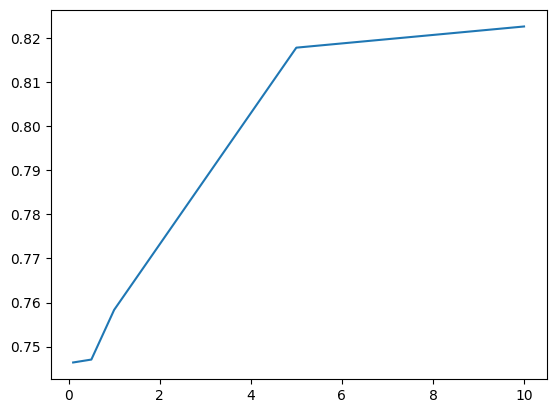

In [7]:
import matplotlib.pyplot as plt

epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
input_acc = []
internal_acc = []
output_acc = []

for eps in epsilons:
    # Input Perturbation
    X_noisy = add_input_noise(X_train, eps)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_noisy, y_train)
    input_acc.append(accuracy_score(y_test, model.predict(X_test)))

    # Internal Perturbation
    #dp_model = DPLogisticRegression(epsilon=eps)
    #dp_model.fit(X_train, y_train)
    #internal_acc.append(accuracy_score(y_test, dp_model.predict(X_test)))

    # Output Perturbation
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    model.coef_ += np.random.laplace(0, 1.0/eps, model.coef_.shape)
    model.intercept_ += np.random.laplace(0, 1.0/eps, model.intercept_.shape)
    output_acc.append(accuracy_score(y_test, model.predict(X_test)))

# Plot
plt.plot(epsilons, input_acc, label='Input Perturbation')
plt.plot(epsilons, internal_acc, label='Internal Perturbation')
plt.plot(epsilons, output_acc, label='Output Perturbation')
plt.xlabel('Privacy Budget ε')
plt.ylabel('Accuracy')
plt.title('Privacy-Utility Tradeoff')
plt.legend()
plt.grid()
plt.show()
